In [21]:
import pandas as pd
import numpy as np
from datetime import datetime, date

from sklearn.linear_model import LinearRegression

import pystan

import matplotlib.pyplot as plt
import seaborn

In [22]:
plt.style.context('seaborn')

In [23]:
df = pd.read_csv(
    'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv', 
    header=None, 
    parse_dates=[0], 
    dtype={1: np.float16}, 
    names=['date', 'level_ppm']
)
df.head()

,date,level_ppm
0,1958-03-29,316.25
1,1958-04-05,317.25
2,1958-04-12,317.75
3,1958-04-19,317.50
4,1958-04-26,316.50


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3210 non-null   datetime64[ns]
 1   level_ppm  3210 non-null   float16       
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.5 KB


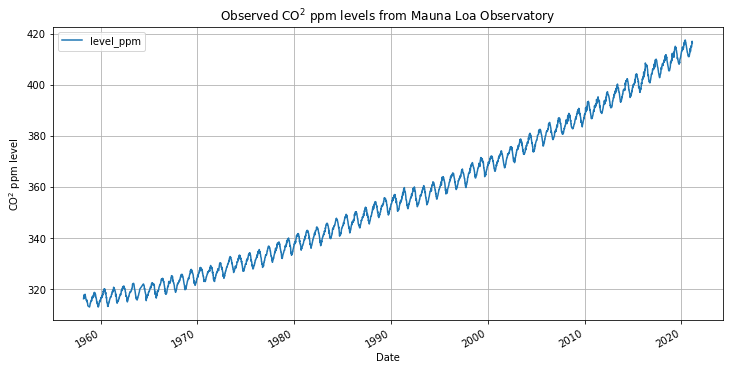

In [25]:
df.plot('date', 'level_ppm', figsize=(12, 6), grid=True)
plt.ylabel('CO$^2$ ppm level')
plt.xlabel('Date')
plt.title('Observed CO$^2$ ppm levels from Mauna Loa Observatory')
plt.savefig('observed_data.png')

In [26]:
days_since_1958 = lambda x: (x.date() - date(1958, 1, 1)).days
df['days'] = df['date'].apply(days_since_1958)
df.head()

,date,level_ppm,days
0,1958-03-29,316.25,87
1,1958-04-05,317.25,94
2,1958-04-12,317.75,101
3,1958-04-19,317.50,108
4,1958-04-26,316.50,115


In [27]:
last_date = date(2060, 2, 1)
future_dates = pd.date_range(start=max(df['date']),end=last_date, freq='7d').to_series()
future_dates_days = future_dates.apply(days_since_1958)
stan_data = {
    'N': len(df),  # number of days since 1 jan 1958
    'nFutureCount': len(future_dates), 
    'y': df['level_ppm'],
    'x': df['days']
}
to_predict_dates = df['date'].append(future_dates)
to_predict = to_predict_dates.apply(days_since_1958)

In [28]:
# Generate starting points for the models
lr = LinearRegression(n_jobs=-1)
lr.fit(
    X = df[['days']],
    y = df[['level_ppm']]
)

LinearRegression(n_jobs=-1)

In [29]:
%%time
bad_stan:str = """
data {
    int<lower=1> N;
    vector[N] y;
    vector[N] x;  // days since 1958
    int<lower=1> nFutureCount;
}

parameters {
    // Linear relationship
    real<lower=-10000, upper=10000> intercept;
    real<lower=0, upper=1>coef;  // Prior knowledge, increasing c02 levels
    // Seasonal variation
    real<lower=0, upper=5> c2;
    real<lower=-2, upper=2> c3;
    real<lower=0>sigma;  // Standard deviation has to be positive
}

model {
    intercept ~ cauchy(-2800, 100);
    coef ~ cauchy(0.005, 0.01);
    c2 ~ cauchy(2.5, 1);
    c3 ~ cauchy(0, 1);
    y ~ normal(
        intercept + coef*x + c2 * cos(2 * pi() * x / 365.25 + c3),
        sigma
    );
}

generated quantities {
   real y_future[nFutureCount];
   for (t in 1:nFutureCount){
    y_future[t] = normal_rng(
      intercept + coef*(x[N] + 7*t) + c2*cos(2*pi()*(x[N] + 7*t)/365.25 + c3),
      sigma
    );
   }
}
"""
bad_stan_model = pystan.StanModel(model_code=bad_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a70c9615046fe73508aef878ef4a8b55 NOW.


CPU times: user 1.2 s, sys: 88.4 ms, total: 1.28 s
Wall time: 56.3 s


In [ ]:
%%time
bad_parameters = ['intercept', 'coef', 'c2', 'c3', 'sigma']
bad_results = bad_stan_model.sampling(
    data=stan_data,
    init=[{
        'intercept': lr.intercept_[0],
        'coef': lr.coef_[0][0]
    }] * 4
)
print(bad_results.stansummary(pars=bad_parameters))
bad_samples = bad_results.extract()

In [ ]:
%%time
pystan.check_hmc_diagnostics(bad_results)

In [ ]:
def get_parameter(parameter:str, results, func = np.mean) -> float:
    return np.mean(results[parameter])

In [ ]:
# Model parameters
bad_intercept = get_parameter('intercept', bad_results)
bad_coef = get_parameter('coef', bad_results)
bad_c2 = get_parameter('c2', bad_results)
bad_c3 = get_parameter('c3', bad_results)

In [ ]:
# Stan model future predictions output
bad_prediction = bad_samples['y_future']

# Compute 95% interval of the predicted values
bad_prediction_interval = np.percentile(bad_prediction, axis=0, q=[2.5, 97.5])

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Bad [Default] Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], bad_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions = bad_intercept + bad_coef* to_predict + bad_c2 * np.cos(2 * np.pi * to_predict / 365.25 + bad_c3)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()
ax.set_title('Observed data, unobserved future data, and predicted 95% interval')
ax.text(
    date(1959, 11, 1), 425, 
    r'Model equation: $intercept + coef \cdot t + c_2 \cos(2 \pi \cdot \frac{t}{365.25} + c_3$)', 
    fontsize=15, bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10}
)
plt.savefig('bad_model.png')
plt.show()

In [8]:
%%time
good_stan: str = """
data {
    int<lower = 0> N;            
    int<lower = 0> nFutureCount; 
    vector[N] y;                 
    vector[N] x;                 
}

parameters {
    //posterior parameters
    real<lower = 0> b;
    real c2;
    real<lower = 0> intercept;
    real<lower = 0> a;
    real<lower = 0> sigma;
}

model {
    // priors
    b ~normal(0, 5);
    intercept ~normal(60000, 10000);

    //likelihood function
    for (t in 1 : N)
    {
        y[t] ~normal(intercept + a * x[t] + b * x[t] ^ 2 + c2 * sin(2 * pi() * x[t] / 365.25), sigma);
    }
}
// future
generated quantities {
    real y_future[nFutureCount];
    for (t in 1 : nFutureCount)
    {
        y_future[t] = normal_rng(intercept + a * (x[N] + 7 * t) + b * (x[N] + 7 * t) ^ 2 + c2 * cos(2 * pi() * (x[N] + 7 * t) / 365.25), sigma);
    }
}
"""
good_stan_model = pystan.StanModel(model_code=good_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_691daf7e0784e5f7339b26dfce031430 NOW.


CPU times: user 1.16 s, sys: 88 ms, total: 1.25 s
Wall time: 54.6 s


In [9]:
%%time
good_parameters = ['intercept', 'a', 'b', 'c2', 'sigma']
good_results = good_stan_model.sampling(
    data=stan_data
)
print(good_results.stansummary(pars=good_parameters))
good_samples = good_results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_691daf7e0784e5f7339b26dfce031430.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean      sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
intercept 314.54  1.6e-3    0.06 314.41 314.49 314.54  314.58 314.67   1728    1.0
a         2.0e-3  3.4e-7  1.3e-5 2.0e-3 2.0e-3 2.0e-3  2.0e-3 2.1e-3   1445   1.01
b         9.9e-8 1.4e-11 5.3e-10 9.8e-8 9.9e-8 9.9e-8 10.0e-8 1.0e-7   1478   1.01
c2           2.7  6.0e-4    0.03   2.64   2.68    2.7    2.72   2.76   2488    1.0
sigma       1.19  3.1e-4    0.01   1.16   1.18   1.19     1.2   1.22   2273    1.0

Samples were drawn using NUTS at Tue Apr 27 01:00:11 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 464 ms, sys: 392 ms, total: 857 ms
Wall time: 2min 39s


In [10]:
%%time
pystan.check_hmc_diagnostics(good_results)

CPU times: user 6.97 s, sys: 34.2 ms, total: 7 s
Wall time: 7.03 s


{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [11]:
# Model parameters
good_intercept = get_parameter('intercept', good_results)
good_a = get_parameter('a', good_results)
good_b = get_parameter('b', good_results)
good_c2 = get_parameter('c2', good_results)

In [12]:
# Stan model future predictions output
good_prediction = good_samples['y_future']

# Compute 95% interval of the predicted values
good_prediction_interval = np.percentile(good_prediction, axis=0, q=[2.5, 97.5])

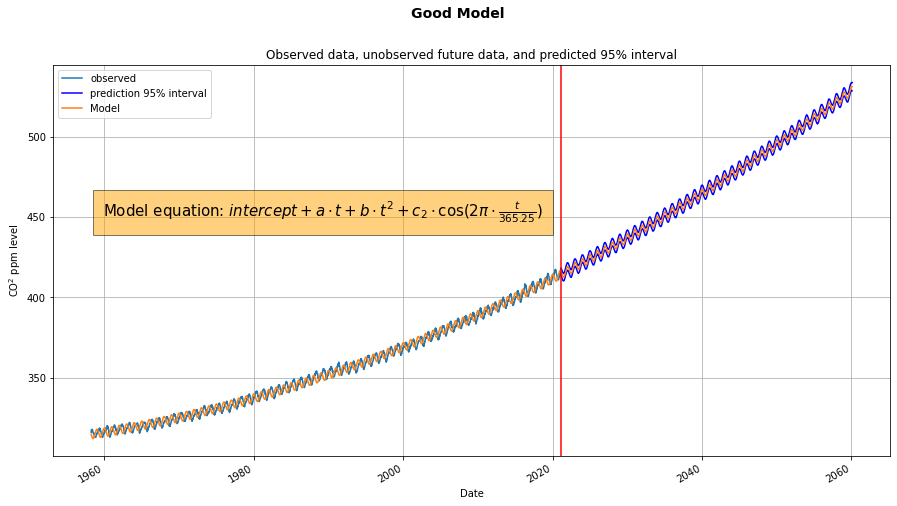

In [13]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot()

fig.suptitle('Good Model', fontsize=14, fontweight='bold')
# Observed data
df.plot('date', 'level_ppm', ax=ax, grid=True, label='observed')

# 95% confidence interval lower and upper bounds
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[0,1:])),
    'b-', label='prediction 95% interval')
ax.plot(
    future_dates,
    np.concatenate((df['level_ppm'][-1:], good_prediction_interval[1,1:])),
    'b-')

# Model
model_predictions =  good_intercept + good_a * to_predict + good_b * to_predict**2 + good_c2 * np.cos(2 * np.pi * to_predict / 365.25)
ax.plot(to_predict_dates, model_predictions, label="Model")

# Last observed date line
ax.axvline(max(df['date']), color='red')
ax.set_xlabel('Date')
ax.set_ylabel('CO$^2$ ppm level')
ax.legend()
ax.set_title('Observed data, unobserved future data, and predicted 95% interval')
ax.text(
    date(1959, 11, 1), 450, 
    r'Model equation: $intercept + a \cdot t + b \cdot t^{2} + c_2 \cdot \cos(2 \pi \cdot \frac{t}{365.25}$)', 
    fontsize=15, bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10}
)
plt.savefig('good_model.png')
plt.show()

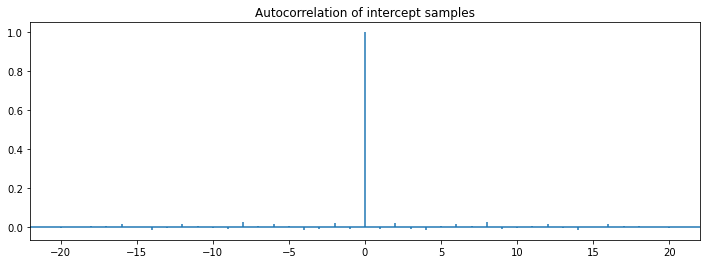

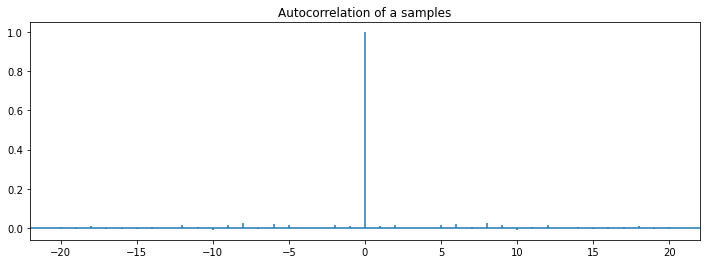

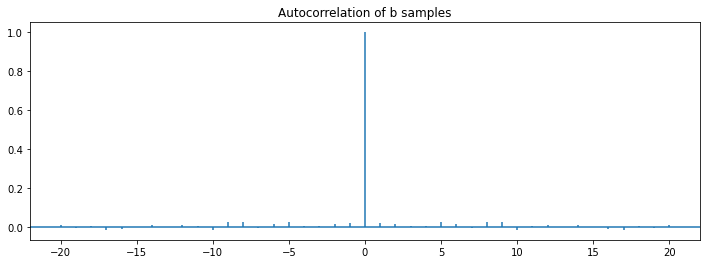

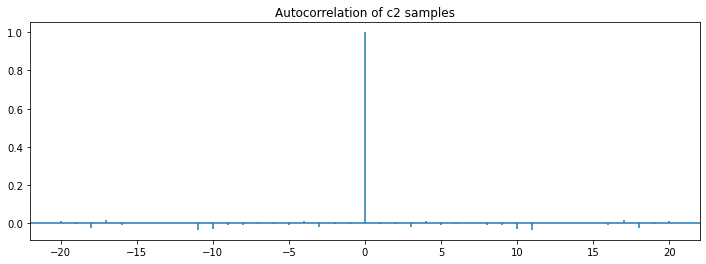

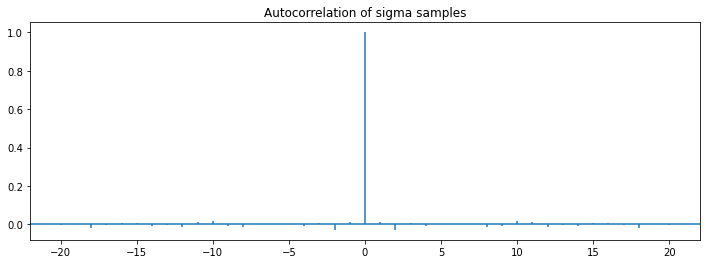

In [15]:
# Plot sample autocorrelation for each parameter.
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for param in good_parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(good_samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

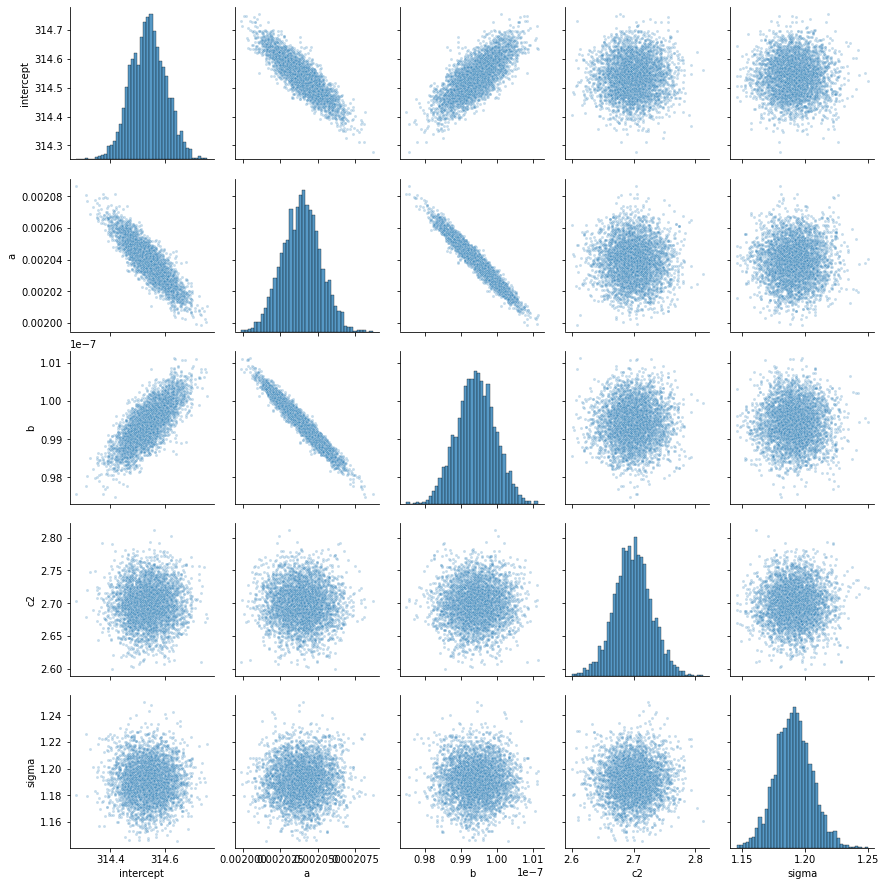

In [19]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([good_samples[param] for param in good_parameters]),
    columns=good_parameters
)
seaborn.pairplot(
    df, 
    height=2.5, 
    plot_kws={'marker': '.', 'alpha': 0.25}
)
plt.show()